In [47]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


# Helper function to draw animation
def plot_animated(x, y, x_noise=None, y_noise=None, x_pred=None, y_pred=None, interval=100, show_clean=True):
    fig, ax = plt.subplots()
    x_concat = np.concatenate([list_x for list_x in [x, x_noise, x_pred] if list_x is not None])
    y_concat = np.concatenate([list_y for list_y in [y, y_noise, y_pred] if list_y is not None])
    _ = ax.set_xlim((min(x_concat), max(x_concat) * 1.1))
    _ = ax.set_ylim((min(y_concat), max(y_concat) * 1.1))
    plot_ball, = ax.plot([], [], "ob", markersize=8)
    plot_clean, = ax.plot([], [], "-y", markersize=1)
    plot_noise, = ax.plot([], [], "xb", markersize=5)
    plot_pred_ball, = ax.plot([], [], "or", markersize=8)
    plot_pred_trace, = ax.plot([], [], "xr", markersize=5)

    def init():
        plot_ball.set_data([], [])
        plot_clean.set_data([], [])
        if x_noise is not None:
            plot_noise.set_data([], [])
        if x_pred is not None:
            plot_pred_ball.set_data([], [])
            plot_pred_trace.set_data([], [])
        return (plot_ball, plot_noise, plot_clean, plot_pred_ball, plot_pred_trace)

    def animate(i):
        plot_ball.set_data(x[i:i+1], y[i:i+1])
        if show_clean:
            plot_clean.set_data(x[:i], y[:i])
        if x_noise is not None:
            plot_noise.set_data(x_noise[:i], y_noise[:i])
        if x_pred is not None:
            plot_pred_trace.set_data(x_pred[:i], y_pred[:i])
            plot_pred_ball.set_data(x_pred[i:i+1], y_pred[i:i+1])
        return (plot_ball, plot_noise, plot_clean, plot_pred_ball, plot_pred_trace)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=x.shape[0], interval=interval, blit=True)
    rc('animation', html='html5')
    return anim

N = 40

x = np.zeros(N)
y = np.zeros(N)
vx = np.zeros(N)
vy = np.zeros(N)

dt = 0.1


+

In [7]:

# Initial position and speed
x[0] = 0
y[0] = 0
vx[0] = 10
vy[0] = 20

ay = -9.8   # Gravity!

for t in range(1, N):
    
    # Update speed
    vx[t] = vx[t-1]            # Constant speed
    vy[t] = vy[t-1] + ay * dt  # Constant acceleration
    
    # Update position
    x[t] = x[t-1] + vx[t] * dt
    y[t] = y[t-1] + vy[t] * dt


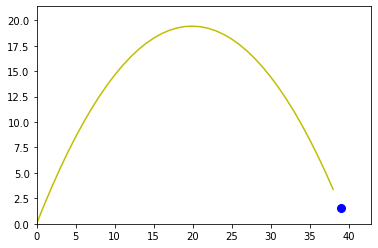

In [8]:
plot_animated(x, y)

In [9]:
# Add noise to measurements
noise_std = 0.6
x_noise = x + np.random.normal(scale=noise_std, size=N)
y_noise = y + np.random.normal(scale=noise_std, size=N)


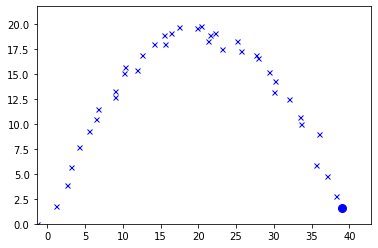

In [48]:
plot_animated(x, y, x_noise, y_noise, show_clean=False)

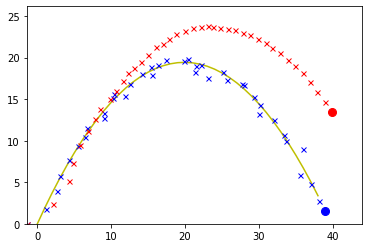

In [54]:
from filterpy.kalman import KalmanFilter
kf = KalmanFilter (dim_x=4, dim_z=2)
kf.x = np.array([0, 0, 0, 0])  # x, vx, y, vy = 0

kf.F = np.array([[1, dt, 0, 0 ],
                 [0, 1,  0, 0 ],
                 [0, 0,  1, dt],
                 [0, 0,  0, 1 ]])

kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])

# Initial prediction error: very big!
kf.P = 100 * np.eye(4)

kf.R = (noise_std ** 2) * np.eye(2)
kf.Q = 0 * np.eye(4)


x_pred = np.zeros(N)
y_pred = np.zeros(N)
for t in range(N):
    # if t % 4 == 0:  # Try this! Predicting every 4 steps
    kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    x_pred[t] = kf.x[0]
    y_pred[t] = kf.x[2]


# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100, show_clean=True)

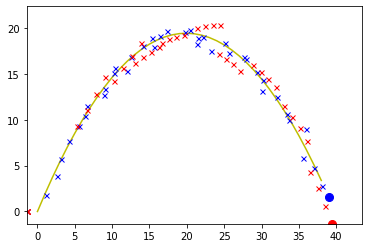

In [55]:
# Filter with 5 state variables: include acceleration

kf = KalmanFilter (dim_x=5, dim_z=2)
kf.x = np.array([0, 0, 0, 0, 0])  # x, vx, y, vy, ay = 0

kf.F = np.array([[1,dt, 0, 0,  0],
                 [0, 1, 0, 0,  0],
                 [0, 0, 1, dt, 0],
                 [0, 0, 0, 1, dt],
                 [0, 0, 0, 0,  1]])

kf.H = np.array([[1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0]])

kf.P = 100 * np.eye(5)

kf.R = (noise_std ** 2) * np.eye(2)
kf.Q = 0.5 * np.eye(5)


x_pred = np.zeros(N)
y_pred = np.zeros(N)

x_hist = np.zeros((N, 5))
for t in range(N):
    if (t % 4) == 0:
        kf.update([x_noise[t], y_noise[t]])
    kf.predict()
    
    x_pred[t] = kf.x[0]
    y_pred[t] = kf.x[2]
    
    # Keep history of all state variables
    x_hist[t, :] = kf.x

    
# Plot predictions
plot_animated(x, y, x_noise, y_noise, x_pred, y_pred, interval=100)

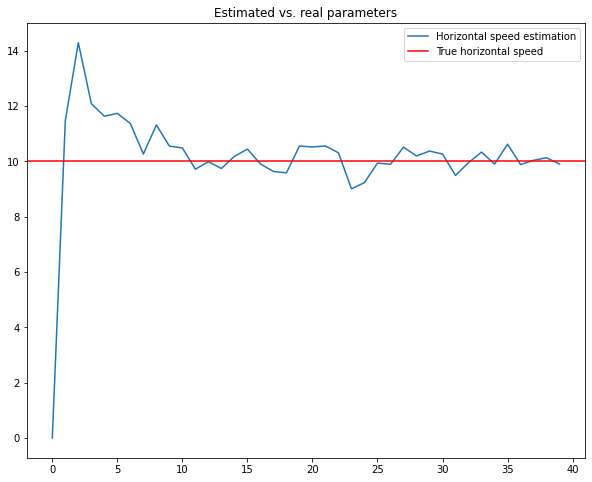

In [44]:
# Plot evolution of some state variables

plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 1], label="Horizontal speed estimation")
plt.axhline(vx[0], color='r', label="True horizontal speed")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")

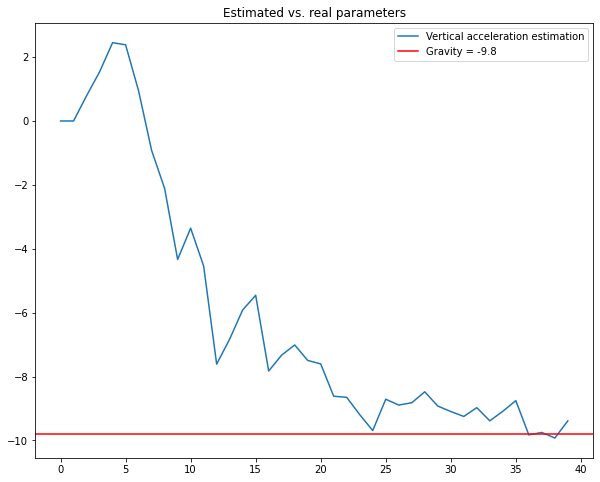

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 4], label="Vertical acceleration estimation")
plt.axhline(ay, color='r', label=f"Gravity = {ay}")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")

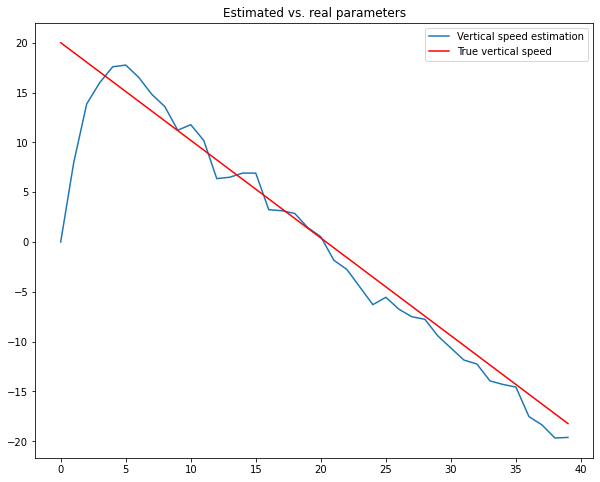

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(x_hist[:, 3], label="Vertical speed estimation")
plt.plot(vy, color='r', label="True vertical speed")

_ = plt.legend()
_ = plt.title("Estimated vs. real parameters")